# 12: Monsters and Mixtures

We are now going to learn about mixture models; models that combine pieces of several different distributions in intereting ways. These types of models can help with over-dispersion, zero-inflation, and ordered categories.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd "/home/ecotner/statistical-rethinking/"

/home/ecotner/statistical-rethinking


In [3]:
import sys, re, warnings

import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.special import factorial
import matplotlib.pyplot as plt
import torch
import torch.tensor as tt
from torch.distributions import TransformedDistribution
import pyro
from pyro.distributions import (
    BetaBinomial,
    Binomial,
    Categorical,
    Delta,
    Dirichlet,
    Exponential,
    Gamma,
    GammaPoisson,
    Normal,
    Poisson,
    TorchDistribution,
    TransformedDistribution,
    ZeroInflatedPoisson,
)
from pyro.distributions.transforms import Transform
from pyro.ops.stats import hpdi, waic, resample
from pyro.infer import Predictive
from pyro.distributions import constraints

sys.path.insert(0, "/home/ecotner/statistical-rethinking/code/")
from utils import train_nuts, unnest_samples, traceplot, precis, plot_intervals

torch.multiprocessing.set_sharing_strategy("file_system")

### Code 12.1 - 12.5
First we will deal with overdispersion, which is where data appears to have a wider variance than is allowed by the base distribution (for example, the Poisson and binomial don't have a lot of leeway to alter the variance while keeping the mean fixed). One example of a distribution that allows you to handle this is the beta-binomial.

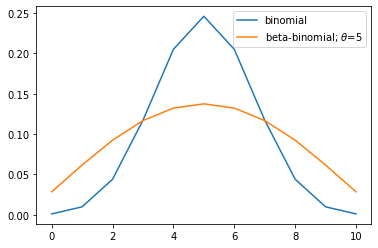

In [245]:
N = 10
p = 0.5
theta = 5
k = torch.arange(N+1).double()
y1 = Binomial(N, probs=p).log_prob(k).exp()
y2 = BetaBinomial(p*(theta-2)+1, (1-p)*(theta-2)+1, N).log_prob(k).exp()
plt.plot(y1, label="binomial")
plt.plot(y2, label=r"beta-binomial; $\theta$=5")
plt.legend()
plt.show()

It gets its name from the fact that it is the distribution you would get if you sampled the binomal parameter $p$ from a beta distribution. This adds a bit more uncertainty to samples from the resulting binomial, so it is broader than the binomial by itself. Let's take a look at the UC Berkely admittance dataset again, and use this distribution to help model the increased variance in admittance rates (without accounting for department):
$$
A_i \sim \text{Beta-Binomial}(N_i, \bar{p}_i, \theta_i) \\
\bar{p}_i = \exp(\alpha_\text{GID[i]}) \\
\alpha \sim \text{Normal}(0, 1.5) \\
\theta \sim \text{Exponential}(1)
$$

In [4]:
ucb_df = pd.read_csv("data/UCBadmit.csv", sep=";")
ucb_df.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


In [5]:
data = {
    "applications": tt(ucb_df["applications"].values).double(),
    "gender_id": tt(ucb_df["applicant.gender"].map({"male": 0, "female": 1}).values).long(),
    "admit": tt(ucb_df["admit"].values).double()
}

In [58]:
def model_m12_1(data, training=False):
    theta = pyro.sample("θ", Exponential(0.5))
    alpha = pyro.sample("α", Normal(0., 1.5).expand([2]).to_event(0))
    pbar = torch.sigmoid(alpha)
    c1, c0 = pbar*(theta-2)+1, (1-pbar)*(theta-2)+1
    c1, c0 = c1[data["gender_id"]], c0[data["gender_id"]]
    if training:
        pyro.sample("obs", BetaBinomial(c1, c0, data["applications"]), obs=data["admit"])
    else:
        return pyro.sample("obs", BetaBinomial(c1, c0, data["applications"]))

In [59]:
m12_1 = train_nuts(model_m12_1, data, 1000, 3000)

Sample: 100%|██████████| 4000/4000 [00:32, 122.69it/s, step size=5.36e-01, acc. prob=0.926]


In [60]:
m12_1.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         θ      2.87      0.94      2.73      1.48      4.30   1484.06      1.00
      α[0]     -0.59      1.32     -0.68     -2.72      1.69   1273.44      1.00
      α[1]     -0.43      1.26     -0.47     -2.35      1.86   1728.74      1.00

Number of divergences: 1


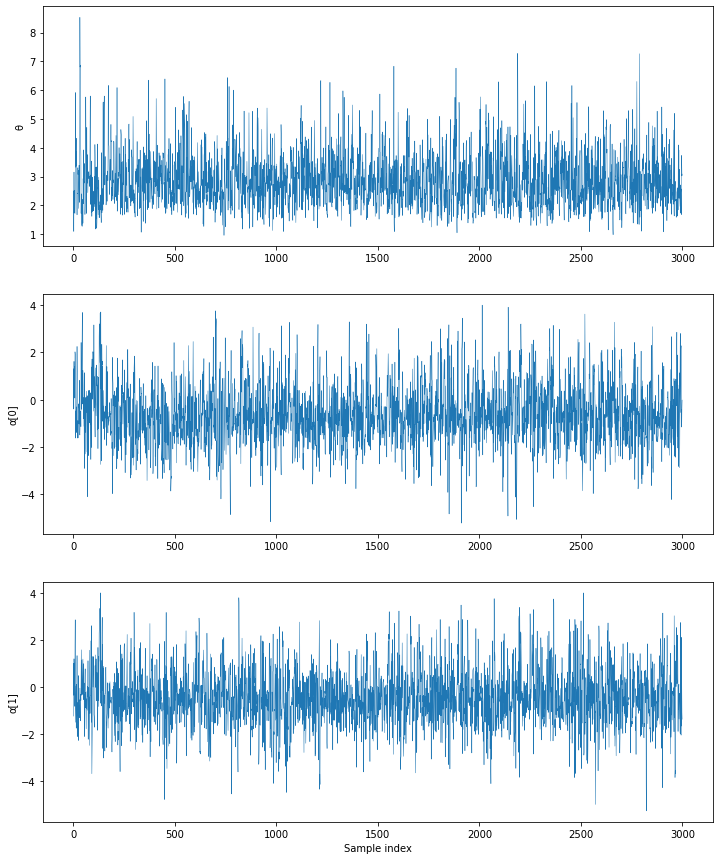

In [61]:
samples = unnest_samples(m12_1.get_samples())
s = {k: v.numpy() for k, v in samples.items()}
traceplot(s)
plt.show()

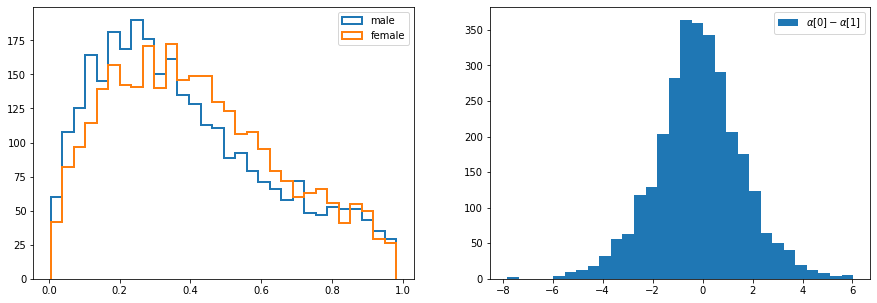

In [62]:
s = unnest_samples(m12_1.get_samples())
s["da"] = s["α[0]"] - s["α[1]"]
s = {k: v.numpy() for k, v in s.items()}
p_male = torch.sigmoid(samples["α[0]"])
p_female = torch.sigmoid(samples["α[1]"])
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plt.sca(axes[0])
plt.hist(p_male, bins=30, histtype="step", linewidth=2, label="male")
plt.hist(p_female, bins=30, histtype="step", linewidth=2, label="female")
plt.legend()
plt.sca(axes[1])
plt.hist(s["da"], bins=30, label=r"$\alpha[0] - \alpha[1]$")
plt.legend()
plt.show()

In [63]:
precis(s)

,mean,stddev,5.5%,94.5%
θ,2.87398,0.943195,1.65406,4.48202
α[0],-0.593272,1.32049,-2.58779,1.70956
α[1],-0.429832,1.25635,-2.37799,1.71008
da,-0.16344,1.73494,-2.98105,2.60998


This model is extremely uncertain about the difference between the genders; but if you recall back to the first time we looked at this data, that model (using a regular binomial distribution) was confounded without using the department as a predictor, and predicted that males had significantly higher admission rates than females. In this case, the model is not confounded because the variation in prior probabilities for $\bar{p}$ can account for the variation in admission rates between departments!

Let's examine the distribution of beta distributions underlying our beta-binomial!

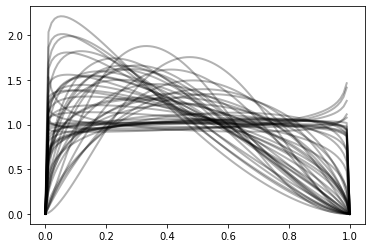

In [64]:
idx = np.random.choice(len(s["θ"]), 50, replace=False)
theta = samples["θ"]
pbar = torch.sigmoid(samples["α[0]"])
c1, c0 = pbar*(theta-2)+1, (1-pbar)*(theta-2)+1
x = np.linspace(0, 1, 100)
for i in idx:
    y = stats.beta.pdf(x, a=c1[i], b=c0[i])
    plt.plot(x, y, color="black", alpha=0.3, linewidth=2)

And we should also do a posterior validation check:

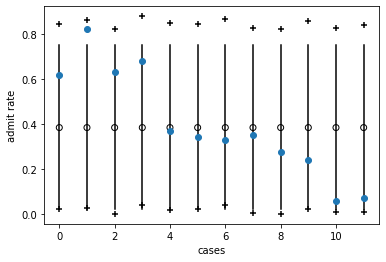

In [69]:
pbar_q = hpdi(pbar, prob=0.89)
pbar_mean = pbar.mean()
for i in range(len(data["applications"])):
    n = data["applications"][i]
    admit_rate_obs = data["admit"][i]/n
    admit_rate = BetaBinomial(c1, c0, n).sample()/n
    q = hpdi(admit_rate, prob=0.89)
    plt.scatter([i, i], q, marker="+", color="black")
    plt.plot([i, i], pbar_q, color="black")
    plt.scatter(i, pbar_mean, facecolor="none", edgecolor="black")
    plt.scatter(i, admit_rate_obs, color="C0", zorder=1000)
plt.xlabel("cases")
plt.ylabel("admit rate")
plt.show()

The beta-binomial distribution obviously captures a lot more of the variation between departments than the binomial by itself.

### Code 12.6
Now we will discuss another over-dispersed model, the gamma-Poisson (sometimes called negative binomial for some reason??), called as such because the conjugate distribution for the Poisson rate paramter is the gamma distribution (and therefore there is an analytic form for the density).

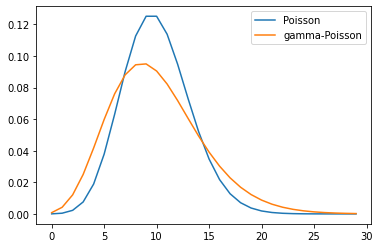

In [86]:
k = torch.arange(30).double()
rate = 10
std = 3
y1 = Poisson(rate).log_prob(k).exp()
a = (rate/std)**2
b = rate/std**2
y2 = GammaPoisson(a, b).log_prob(k).exp()
plt.plot(k, y1, label="Poisson")
plt.plot(k, y2, label="gamma-Poisson")
plt.legend()
plt.show()

The increased variance of the gamma-Poisson model will be useful if we revisit the Oceanic tools data from the previous chapter. Recall that Hawaii was kind of an outlier/influential point that changed the results significantly. What if we instead used a gamma-Poisson model instead of a Poisson?

In [91]:
tools_df = pd.read_csv("data/Kline.csv", sep=";")
tools_df["log_pop"] = np.log(tools_df["population"])
tools_df.head()

,culture,population,contact,total_tools,mean_TU,log_pop
0,Malekula,1100,low,13,3.2,7.003065
1,Tikopia,1500,low,22,4.7,7.313220
2,Santa Cruz,3600,low,24,4.0,8.188689
3,Yap,4791,high,43,5.0,8.474494
4,Lau Fiji,7400,high,33,5.0,8.909235


In [107]:
df = tools_df
data = {
    "log_P": tt(((df["log_pop"] - df["log_pop"].mean())/df["log_pop"].std()).values).double(),
    "pop": tt(df["population"].values).double(),
    "contact": tt(df["contact"].map({"low": 0, "high": 1}).values).long(),
    "tools": tt(df["total_tools"].values).double(),
}

In [151]:
def model_m12_2(data, training=False):
    a = pyro.sample("a", Normal(1., 1.).expand([2]).to_event(0))
    b = pyro.sample("b", Exponential(1.).expand([2]).to_event(0))
    g = pyro.sample("g", Exponential(1.))
    sigma = pyro.sample("sigma", Exponential(1.))
    cid = data["contact"]
    P = data["pop"]
    _lambda = pyro.deterministic("lambda", torch.exp(a[cid]) * (P**b[cid])/g)
    alpha = (_lambda/sigma)**2
    beta = _lambda/sigma**2
    if training:
        pyro.sample("T", GammaPoisson(alpha, beta), obs=data["tools"])
    else:
        pyro.sample("T", GammaPoisson(alpha, beta))

In [143]:
m12_2 = train_nuts(model_m12_2, data, 1000, 3000, 1)

Sample: 100%|██████████| 4000/4000 [07:44,  8.61it/s, step size=4.69e-02, acc. prob=0.899]


In [144]:
m12_2.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      0.92      0.69      0.95     -0.33      1.92   1180.48      1.00
      a[1]      0.91      0.85      0.94     -0.51      2.26   1249.85      1.00
      b[0]      0.26      0.04      0.26      0.20      0.32   1510.79      1.00
      b[1]      0.29      0.11      0.29      0.12      0.46    963.00      1.00
         g      1.16      0.77      0.97      0.18      2.26   1257.78      1.00
     sigma      1.43      1.39      0.97      0.00      3.36   1888.06      1.00

Number of divergences: 4


In [145]:
T.shape

torch.Size([3000, 100])

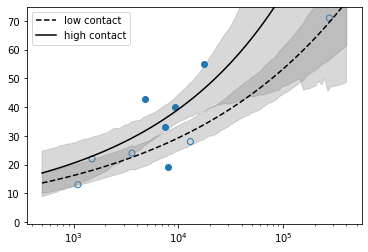

In [154]:
cid = data["contact"]
# low contact
d = {
    "pop": tt(np.geomspace(500, 400_000, 100)),
    "contact": torch.zeros((100,), dtype=torch.long),
}
T = Predictive(model_m12_2, m12_2.get_samples(), return_sites=("lambda",))(d)["lambda"]
q = hpdi(T, 0.89, dim=0)
mean = T.mean(dim=0)
plt.plot(d["pop"], mean, color="black", linestyle="--", label="low contact")
plt.fill_between(d["pop"], *q, color="gray", alpha=0.3)
plt.scatter(data["pop"][cid==0], data["tools"][cid==0], facecolor="none", edgecolor="C0")
# high contact
d["contact"] = torch.ones((100,), dtype=torch.long)
T = Predictive(model_m12_2, m12_2.get_samples(), return_sites=("lambda",))(d)["lambda"]
q = hpdi(T, 0.89, dim=0)
mean = T.mean(dim=0)
plt.plot(d["pop"], mean, color="black", linestyle="-", label="high contact")
plt.fill_between(d["pop"], *q, color="gray", alpha=0.3)
plt.scatter(data["pop"][cid==1], data["tools"][cid==1], color="C0")
plt.legend()
plt.xscale("log")
plt.ylim(top=75)
plt.show()

For some reason, it does not look nearly as dispersed as the example in the textbook, and Hawaii is still highly influential for the low-contact societies...

### Code 12.7 - 12.11
Now we'll go over a class of mixture models known as zero-inflated models. Zero-inflated processes can arise when there are multiple ways to get a zero result from a process. For example, if we are modeling the number of manuscripts completed by monks at a monastery on any given day, on every day the monks work, they generate some number of manuscripts that is Poisson-distributed. However, on some days the monks go down into the cellar and drink, and no manuscripts are completed on that day. If they had been working, perhaps by chance no manuscripts may have been completed, but on the days they drink, they are guaranteed to not produce anything.

If the probability that the monks take a break and drink is $p$, and the probability that $k$ manuscripts are produced if they don't is given by a Poisson distribution, then the probability of getting zero (through either process) is
$$\begin{align}
\text{Pr}(0|p,\lambda) &= \text{Pr}(\text{drink}|p) + \text{Pr}(\text{work}|p) \times \text{Pr}(0|\lambda) \\
&= p + (1-p) \exp(-\lambda)
\end{align}$$
and the probability of getting $k>0$ is
$$\begin{align}
\text{Pr}(k|p,\lambda) &= \text{Pr}(\text{work}|p) \times \text{Pr}(k|\lambda) \\
&= (1-p) \frac{e^{-\lambda} \lambda^k}{k!}
\end{align}$$

Let's simulate some data and then try to recover the parameters used.

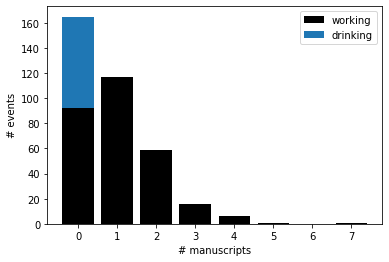

In [212]:
# define parameters
prob_drink = 0.2
rate_work = 1.
# sample one year
N = 365
# simulate days monks drink
drink = Binomial(1, prob_drink).sample([N])
# simulate productive days
manuscripts = (1 - drink)*Poisson(rate_work).sample([N])
# make histogram
x, y = np.unique(manuscripts, return_counts=True)
plt.bar(x, y, color="black", label="working")
zeros_drink = drink.sum()
zeros_work = ((manuscripts == 0) & (drink == 0)).sum()
plt.bar([0], [zeros_drink], bottom=zeros_work, color="C0", label="drinking")
plt.ylabel("# events")
plt.xlabel("# manuscripts")
plt.legend()
plt.show()

In [213]:
data = {"manuscripts": manuscripts}

def model_m12_4(data, training=False):
    ap = pyro.sample("ap", Normal(-1., 1.5))
    al = pyro.sample("al", Normal(1., 0.5))
    lambda_ = torch.exp(al)
    p = torch.sigmoid(ap)
    if training:
        pyro.sample("M", ZeroInflatedPoisson(p, lambda_), obs=data["manuscripts"])
    else:
        return pyro.sample("M", ZeroInflatedPoisson(p, lambda_))
    
m12_4 = train_nuts(model_m12_4, data, 1000, 3000)

Sample: 100%|██████████| 4000/4000 [00:27, 145.58it/s, step size=3.83e-01, acc. prob=0.957]


In [214]:
m12_4.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        ap     -1.87      0.56     -1.77     -2.66     -1.02    687.83      1.00
        al      0.03      0.08      0.03     -0.10      0.17    709.70      1.00

Number of divergences: 0


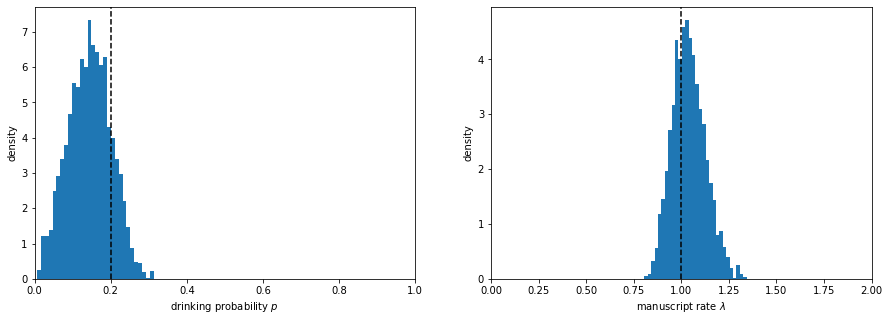

In [215]:
s = m12_4.get_samples()
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plt.sca(axes[0])
plt.hist(torch.sigmoid(s["ap"]), bins=30, density=True)
plt.axvline(0.2, color="black", linestyle="--")
plt.xlabel(r"drinking probability $p$")
plt.ylabel("density")
plt.xlim(left=0, right=1)
plt.sca(axes[1])
plt.hist(torch.exp(s["al"]), bins=30, density=True)
plt.axvline(1, color="black", linestyle="--")
plt.xlabel(r"manuscript rate $\lambda$")
plt.ylabel("density")
plt.xlim(left=0, right=2)
plt.show()

Not bad; we recover the parameters fairly well (see above; true values are vertical dashed lines).

### Code 12.12 - 12.29
Now we will discuss ordered categorical models. This type of model arises whenever we have a categorical variable that doesn't have a direct numerical interpretation, but nevertheless does have some sort of order (e.g. "worst" < "bad" < "good" < "better" < "best"). We will analyze this in the context of "trolley problems", where someone is placed in a hypothetical situation involving a runaway trolley which will end up killing various people depending on the choices made.

In [4]:
trolley_df = pd.read_csv("data/Trolley.csv", sep=";")
print(len(trolley_df), "rows")
trolley_df.head()

9930 rows


,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


In order to enforce the ordering of the response variables (so that increasing one of the associated predictor variables increases the response), we will use a cumulative link function. Basically, each outcome level gets its own "intercept" $\alpha_k$ that is related to the cumulative probability via
$$
\log\left(\frac{Pr(y_i \le k)}{1 - Pr(y_i \le k)}\right) = \alpha_k
$$
You will notice that this is the logit function, so its inverse is the sigmoid $Pr(y_i \le k) = \sigma(\alpha_k) = e^{\alpha_k}/(1+e^{\alpha_k})$. The idea is that as we introduce predictor variables, we add them onto $\alpha_k$ as a linear model, then do the sigmoid thing to convert them into cumulative

/home/ecotner/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


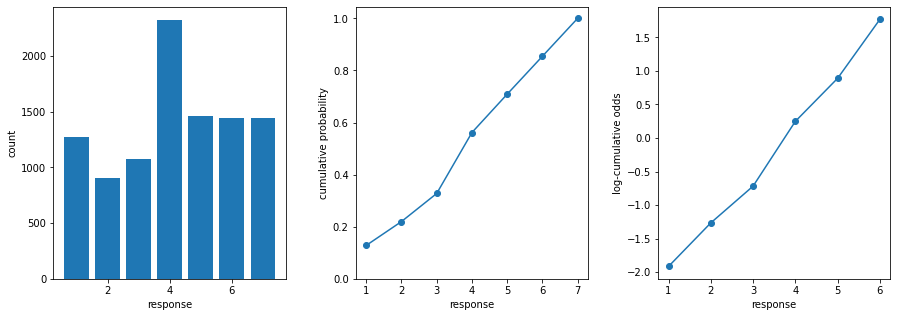

In [5]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
plt.sca(axes[0])
x, y = np.unique(trolley_df["response"], return_counts=True)
plt.bar(x, y)
plt.xlabel("response")
plt.ylabel("count")
plt.sca(axes[1])
y = np.cumsum(y)/y.sum()
plt.plot(x, y, marker="o")
plt.xlabel("response")
plt.ylabel("cumulative probability")
plt.ylim(bottom=0)
plt.sca(axes[2])
plt.plot(x, np.log(y/(1-y)), marker="o")
plt.xlabel("response")
plt.ylabel("log-cumulative odds")
plt.subplots_adjust(wspace=0.3)
plt.show()

As part of inference, we will need the likelihood of getting a particular response $Pr(y_i = k)$. If we have the cumulative probability, then this is simply
$$
p_k = Pr(y_i = k) = Pr(y_i \le k) - Pr(y_i \le k-1) = \sigma(\alpha_k) - \sigma(\alpha_{k-1})
$$

This implies a model such as
$$\begin{align}
R_i &\sim \text{Categorial}(\boldsymbol{p}) \\
p_0 &= q_0 \\
p_k &= q_k - q_{k-1} \qquad 2 < k < K-1 \\
p_{K-1} &= 1 - q_{K-1} \\
q_k &= \sigma(\alpha_k - \phi_i) \\
\phi_i &= \text{some kind of (linear?) model of predictor variables} \\
\alpha_k &\sim \text{Normal}(0, 1.5)
\end{align}$$

In [6]:
data = {
    "num_levels": trolley_df["response"].nunique(),
    "num_rows": len(trolley_df),
    "response": tt(trolley_df["response"].values-1).double(),
}

In [288]:
import torch
from torch.distributions import constraints
from pyro.distributions import TorchDistribution, Categorical

class OrderedCategorical(TorchDistribution):
    """
    Alternative parametrization of the distribution over a categorical variable.
    
    Instead of the typical parametrization of a categorical variable in terms
    of the probability mass of the individual categories ``p``, this provides an
    alternative that is useful in specifying ordered categorical models. This
    accepts a list of ``cutpoints`` which are a (potentially initially unordered)
    vector of real numbers denoting baseline cumulative log-odds of the individual
    categories, and a model vector ``phi`` which modifies the baselines for each
    sample individually.
    
    These cumulative log-odds are then transformed into a discrete cumulative
    probability distribution, that is finally differenced to return the probability
    mass function ``p`` that specifies the categorical distribution.
    """
    support = constraints.nonnegative_integer
    arg_constraints = {"phi": constraints.real, "cutpoints": constraints.real}
    has_rsample = False
    
    def __init__(self, phi, cutpoints):
        assert len(cutpoints.shape) == 1 # cutpoints must be 1d vector
        assert len(phi.shape) == 1 # model terms must be 1d vector of samples
        N, K = phi.shape[0], cutpoints.shape[0]+1
#         cutpoints = torch.sort(cutpoints).values.reshape(1, -1)  # sort and reshape for broadcasting
        cutpoints = cutpoints.reshape(1, -1)
        q = torch.sigmoid(cutpoints - phi.reshape(-1, 1))  # cumulative probabilities
        # turn cumulative probabilities into probability mass of categories
        p = torch.zeros((N, K)) # (batch/sample dim, categories)
        p[:,0] = q[:,0]
        p[:,1:-1] = (q - torch.roll(q, 1, dims=1))[:,1:]
        p[:,-1] = 1 - q[:,-1]
        self.cum_prob = q
        self.dist = Categorical(p)
        
    def sample(self, *args, **kwargs):
        return self.dist.sample(*args, **kwargs)
    
    def log_prob(self, *args, **kwargs):
        return self.dist.log_prob(*args, **kwargs)
    
    @property
    def _event_shape(self):
        return self.dist._event_shape
    
    @property
    def _batch_shape(self):
        return self.dist._batch_shape

In [243]:
import torch
from pyro.distributions.transforms import Transform
from torch.distributions.utils import lazy_property
from torch.distributions import constraints

class OrderedTransform(Transform):
    codomain = constraints.real_vector
    bijective = True

    def __init__(self):
        super().__init__()

    def _call(self, x):
        """
        :param x: the input into the bijection
        :type x: torch.Tensor

        Invokes the bijection x=>y; in the prototypical context of a
        :class:`~pyro.distributions.TransformedDistribution` `x` is a sample from
        the base distribution (or the output of a previous transform)
        """
        z = torch.cat([x[..., :1], torch.exp(x[..., 1:])], dim=-1)
        return torch.cumsum(z, dim=-1)

    def _inverse(self, y):
        """
        :param y: the output of the bijection
        :type y: torch.Tensor

        Inverts y => x.
        """
        x = torch.log(y[..., 1:] - y[..., :-1])
        return torch.cat([y[..., :1], x], dim=-1)

    def log_abs_det_jacobian(self, x, y):
        """
        Calculates the elementwise determinant of the log Jacobian, i.e.
        log(abs([dy_0/dx_0, ..., dy_{N-1}/dx_{N-1}])).
        """

        return torch.sum(x[..., 1:], dim=-1)

In [244]:
def model_m12_5(data, training=False):
    N = data["num_rows"] #data["response"].shape[0]
    K = data["num_levels"]
#     cp_dist = TransformedDistribution(Normal(0., 0.5).expand([K-1]).to_event(0), OrderedTransform())
    cp_dist = Normal(0., 1.5).expand([K-1]).to_event(0)
    cutpoints = pyro.sample("cutpoints", cp_dist)
    phi = torch.zeros_like(data["response"])
#     phi = torch.ones_like(data["response"]) * pyro.sample("a", Normal(0., 1.))
    if training:
        pyro.sample("R", OrderedCategorical(phi, cutpoints), obs=data["response"])
    else:
        return pyro.sample("R", OrderedCategorical(phi, cutpoints))

In [245]:
m12_5 = train_nuts(model_m12_5, data, 200, 2000)

Sample: 100%|██████████| 2200/2200 [02:01, 18.17it/s, step size=3.40e-01, acc. prob=0.926]


In [246]:
m12_5.summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
cutpoints[0]     -1.92      0.03     -1.92     -1.97     -1.86    561.97      1.00
cutpoints[1]      0.89      0.02      0.89      0.85      0.92    752.07      1.00
cutpoints[2]     -1.27      0.03     -1.27     -1.31     -1.22    537.14      1.00
cutpoints[3]      0.25      0.02      0.25      0.22      0.28    705.17      1.00
cutpoints[4]      1.77      0.03      1.77      1.72      1.82    999.48      1.00
cutpoints[5]     -0.72      0.02     -0.72     -0.76     -0.68    580.29      1.00

Number of divergences: 0


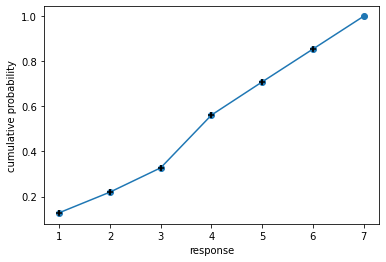

In [250]:
# plot data
x, y = np.unique(trolley_df["response"], return_counts=True)
y = np.cumsum(y)/y.sum()
plt.plot(x, y, marker="o")
# plot inferred values
s = m12_5.get_samples()
s["cutpoints"] = torch.sort(s["cutpoints"], dim=1).values
s["cum_p"] = torch.sigmoid(s["cutpoints"])
q = hpdi(s["cum_p"], 0.89, dim=0)
mean = s["cum_p"].mean(dim=0)
for i in x[:-1]:
    plt.plot([i, i], q[:,i-1], color="black")
    plt.scatter(i, mean[i-1], color="black", marker="+", zorder=100)
plt.xlabel("response")
plt.ylabel("cumulative probability")
plt.show()

The order of the cutpoints are all jumbled (we can sort after the fact), but they agree with the values in the text, and the values we computed earlier. Now, it's great that we now have all these cutpoints, but all we have now is essentially just a Bayesian version of a histogram (though the error bars, given by the + symbols, are extremely small). Next, we'll add our linear model $\phi_i$.

The model is given by
$$
\phi_i = \beta_A A_i + \beta_C C_i + B_{I,i}I_i \\
B_{I,i} = \beta_I + \beta_{IA} A_i + \beta_{IC} C_i
$$
$A$, $C$ and $I$ are the presence of "action", "contact", and "intention" in each of the trolley problem descriptions, and we want to see if some combination of them will lead to changes in the way the trolley problem is interpreted. We can see that there are interaction effects through the term $B_{I,i}$. Notably, we exclude an interaction term of the form $C_i A_i$ because contact precludes action.

In [251]:
trolley_df.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


In [252]:
data = {
    "num_levels": trolley_df["response"].nunique(),
    "num_rows": len(trolley_df),
    "response": tt(trolley_df["response"].values-1).double(),
    "action": tt(trolley_df["action"].values).long(),
    "intention": tt(trolley_df["intention"].values).long(),
    "contact": tt(trolley_df["contact"].values).long(),
}

In [211]:
def model_m12_6(data, training=False):
    N = data["num_rows"] #data["response"].shape[0]
    K = data["num_levels"]
    cutpoints = pyro.sample("cutpoints", Normal(0., 1.5).expand([K-1]).to_event(0))
    A, I, C = [data[k] for k in ("action", "intention", "contact")]
    b = {k: pyro.sample("b"+k, Normal(0., 0.5)) for k in ("A","C","I","IC","IA")}
    BI = b["I"] + b["IA"]*A + b["IC"]*C
    phi = (b["A"]*A + b["C"]*C + BI*I)
    if training:
        pyro.sample("R", OrderedCategorical(phi, cutpoints), obs=data["response"])
    else:
        return pyro.sample("R", OrderedCategorical(phi, cutpoints))

In [212]:
m12_6 = train_nuts(model_m12_6, data, 300, 1000)

Sample: 100%|██████████| 1300/1300 [02:13,  9.76it/s, step size=2.43e-01, acc. prob=0.911]


In [213]:
m12_6.summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
cutpoints[0]     -0.31      0.04     -0.31     -0.38     -0.24    130.65      1.00
cutpoints[1]     -2.63      0.05     -2.64     -2.72     -2.55    151.43      1.00
cutpoints[2]      0.36      0.04      0.36      0.29      0.43    137.37      1.00
cutpoints[3]     -1.34      0.05     -1.34     -1.42     -1.27    127.67      1.00
cutpoints[4]      1.27      0.05      1.27      1.19      1.35    161.35      1.00
cutpoints[5]     -1.94      0.05     -1.94     -2.01     -1.85    131.06      1.00
          bA     -0.47      0.06     -0.48     -0.57     -0.39    153.17      1.00
          bC     -0.34      0.07     -0.34     -0.46     -0.23    243.65      1.00
          bI     -0.29      0.06     -0.29     -0.38     -0.20    166.43      1.00
         bIC     -1.24      0.10     -1.24     -1.41     -1.10    302.72      1.01
         bIA     -0.44      0.08     -0.44     -0.57     -0.31    226.38      1.00

Nu

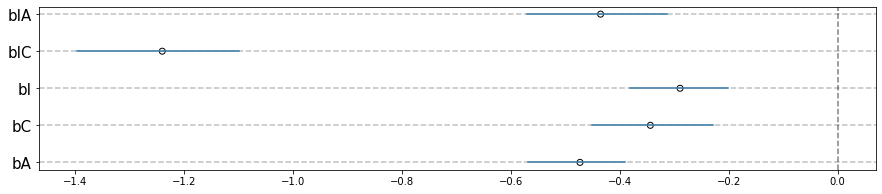

In [214]:
samples = m12_6.get_samples()
s = {k: v.numpy() for k, v in samples.items() if k != "cutpoints"}
plt.figure(figsize=(15, 3))
plot_intervals(s, 0.89); plt.show()

Interesting... so the presence of any of action, contact or intent causes mild reduction in response (as well as the combo of intent/action), but the combination of intent and contact (e.g. intentionally trying to injure someone, for example) REALLY makes pulling the lever morally questionable. Perhaps not terribly surprising when you think about it, but now we have statistical evidence to support it!

Let's do some more visualization. First I'll make some plots showing how the cumulative probabilities change as we change the predictor variables. In particular, how do they change if we switch intention from 0 to 1?

In [221]:
def model_m12_6(data, training=False):
    N = data["num_rows"] #data["response"].shape[0]
    K = data["num_levels"]
    cutpoints = pyro.sample("cutpoints", Normal(0., 1.5).expand([K-1]).to_event(0))
    A, I, C = [data[k] for k in ("action", "intention", "contact")]
    b = {k: pyro.sample("b"+k, Normal(0., 0.5)) for k in ("A","C","I","IC","IA")}
    BI = b["I"] + b["IA"]*A + b["IC"]*C
    phi = (b["A"]*A + b["C"]*C + BI*I)
    dist = OrderedCategorical(phi, cutpoints)
    pyro.deterministic("q", dist.cum_prob)
    if training:
        pyro.sample("R", dist, obs=data["response"])
    else:
        return pyro.sample("R", dist)

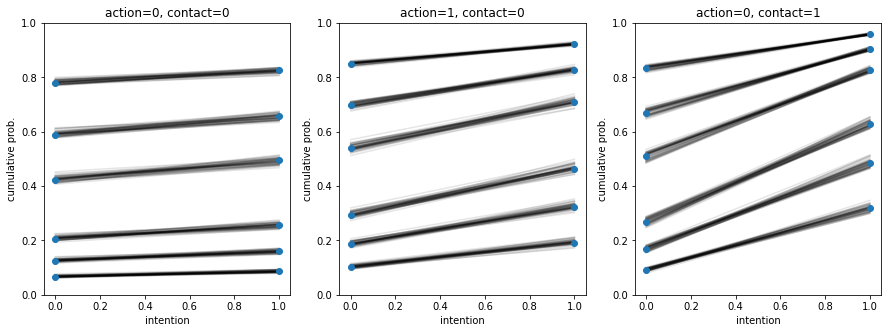

In [222]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
d = dict(intention=tt([0., 1.]), num_rows=2, num_levels=7)
for (a, c), ax in zip(((0., 0.), (1., 0.), (0., 1.)), axes):
    plt.sca(ax)
    d["action"] = tt([a, a])
    d["contact"] = tt([c, c])
    samples = {k: v.squeeze() for k, v in Predictive(model_m12_6, m12_6.get_samples(), return_sites=("q",))(d).items()}
    mean = samples["q"].mean(dim=0)
    for i in range(samples["q"].shape[-1]):
        plt.scatter([0, 1], mean[:,i], color="C0")
        for s in range(50):
            plt.plot([0, 1], samples["q"][s,:,i], color="black", alpha=0.1, zorder=-1)
    plt.xlabel("intention")
    plt.ylabel("cumulative prob.")
    plt.ylim(bottom=0, top=1)
    plt.title(f"action={int(a)}, contact={int(c)}")

### Code 12.30 - 12.??
Now that we've explored ordered categorical response variables, what do we do about ordered predictor variables? These are what we would have as _input_ to the model rather than _output_. We will explore this through the `edu` variable in the trolley dataset, which describes the highest level of education attained by the subject.

In [253]:
trolley_df["edu"].unique()

array(['Middle School', "Bachelor's Degree", 'Some College',
       "Master's Degree", 'High School Graduate', 'Graduate Degree',
       'Some High School', 'Elementary School'], dtype=object)

There are 8 different levels, so we will need to encode them in the proper order.

In [254]:
trolley_df["edu_levels"] = trolley_df["edu"].map({k: i for i, k in enumerate([
    "Elementary School", "Middle School", "Some High School", "High School Graduate",
    "Some College", "Bachelor's Degree", "Master's Degree", "Graduate Degree"
])})

The way we account for this mathematically is to introduce several variables $\delta_i$ (one for each level of the predictor minus one; the first can be absorbed into the intercept) to represent the incremental effect of each level of the predictor, like so:
$$
\phi_i = \sum_{j=0}^{E_i-1} \delta_j + \text{other terms...}
$$
where $E_i$ is the educational level of data point $i$. The text recommends adding a simplex constraint to the $\delta_i$'s (they are positive and sum to one), and extracting the overall sum as a separate variable $\beta_E$:
$$
\phi_i = \beta_E \sum_{j=0}^{E_i-1} \delta_j + \text{other terms...}
$$

So now this piece of our model can be combined with some of the other terms from before to get
$$\begin{align}
R_i &\sim \text{Ordered-logit}(\phi_i, \kappa) \\
\phi_i &= \beta_E \sum_{j=0}^{E_i-1} \delta_j + \beta_A A_i + \beta_I I_i + \beta_C C_i \\
\kappa_k &\sim \text{Normal}(0, 1.5) \\
\beta_E, \beta_A, \beta_I, \beta_C &\sim \text{Normal}(0, 1) \\
\delta &\sim \text{Dirichlet}(\alpha)
\end{align}$$
I guess we're neglecting the interaction between $I$ and the other problem type variables. The Dirichlet distribution we haven't seen thus far in the book, so it needs introducing. It's essentially a generalization of the beta distribution. Recall the beta is a distribution for a single probability parameter $p$. Now imagine that it also implictly defines the distribution for the _complement_ to that probability, $1-p$. Together, these two probability masses sum to unity ($p + (1-p) = 1$). Now imagine that instead of just two probabilities $p_1 = p$ and $p_2 = 1-p$, there are $N$ different probabilities that all sum to unity $\sum_{i=1}^N p_i = 1$ (also known as the _simplex_ constraint). The Dirichlet is one distribution that satisfies this constraint. The hyperparameter $\alpha$ is a vector of real numbers that can be thought of as (pseudo-)counts of events belonging to a category (i.e. $\alpha_i$ is the count of events observed belonging to category $i$)

In [255]:
data = {
    "num_levels": trolley_df["response"].nunique(),
    "num_rows": len(trolley_df),
    "response": tt(trolley_df["response"].values-1).double(),
    "action": tt(trolley_df["action"].values).long(),
    "intention": tt(trolley_df["intention"].values).long(),
    "contact": tt(trolley_df["contact"].values).long(),
    "edu": tt(trolley_df["edu_levels"].values).long(),
}
data["mask"] = (torch.arange(7)[None,:] < data["edu"][:,None])

In [522]:
def model_m12_7(data, training=False):
    N = data["num_rows"]
    K = data["num_levels"]
    cutpoints = pyro.sample("cutpoints", Normal(-1.5, 1.5).expand([K-1]).to_event(0))
    cutpoints = cutpoints.exp().cumsum(-1).log()
    A, I, C = [data[k] for k in ("action", "intention", "contact")]
    b = {k: pyro.sample("b"+k, Normal(0., 1.)) for k in ("A","C","I","E")}
    d = pyro.sample("delta", Dirichlet(tt(7*[2.])))
    a = pyro.sample("a", Normal(0., 1.))
    phi = a + (b["A"]*A + b["C"]*C + b["I"]*I) + b["E"]*(d[None,:]*data["mask"]).sum(dim=1)
#     phi = torch.zeros_like(data["response"])
    dist = OrderedCategorical(phi, cutpoints)
    if training:
        pyro.sample("R", dist, obs=data["response"])
    else:
        return pyro.sample("R", dist)

In [523]:
m12_7 = train_nuts(model_m12_7, data, 500, 500)

Warmup:   0%|          | 0/1000 [00:00, ?it/s]/home/ecotner/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  
Sample: 100%|██████████| 1000/1000 [17:54,  1.07s/it, step size=3.36e-02, acc. prob=0.902]


In [527]:
m12_7.summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
cutpoints[0]     -2.83      0.51     -2.80     -3.74     -2.04     63.81      1.00
cutpoints[1]     -2.85      0.51     -2.82     -3.80     -2.10     63.38      1.00
cutpoints[2]     -2.39      0.51     -2.36     -3.28     -1.62     64.43      1.00
cutpoints[3]     -0.99      0.51     -0.96     -1.90     -0.20     64.17      1.00
cutpoints[4]     -0.60      0.51     -0.56     -1.55      0.14     63.77      1.00
cutpoints[5]      0.52      0.51      0.54     -0.40      1.29     62.73      1.00
          bA     -0.71      0.04     -0.71     -0.77     -0.64    654.61      1.00
          bC     -0.96      0.05     -0.96     -1.05     -0.89    678.30      1.00
          bI     -0.72      0.04     -0.72     -0.78     -0.66    445.67      1.00
          bE     -0.41      0.21     -0.39     -0.75     -0.08    348.47      1.00
    delta[0]      0.28      0.16      0.26      0.02      0.52    480.68      1.00
   

It might not seem like it, but this last model took forever to figure out. The problem was that I was _sorting_ the cutpoints before passing them to the ordered logit model, and this was causing an identification problem, because the cutpoints were therefore permutation invariant. So the MCMC chain was jumping around from cutpoint to cutpoint without settling down. The solution to this was pretty simple; exponentiate the cutpoints (so that they were all positive), then take the cumulative sum (so that the output was in increasing order), then take the log (a monotonic transformation to try and undo the explosive effect of exponentiation). This seems to have had pretty good results, as you can see below; the cutpoints now seem to be decently well-separated.

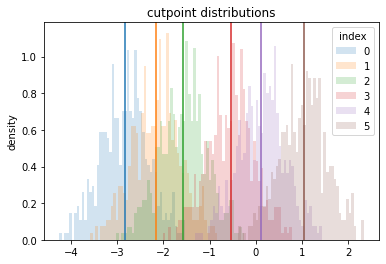

In [540]:
samples = m12_7.get_samples()
v = samples["cutpoints"].exp().cumsum(-1).log()
for i in range(v.shape[-1]):
    plt.hist(v[:,i], bins=50, label=i, alpha=0.2, histtype="stepfilled", density=True)
    plt.axvline(v[:,i].mean(), color=f"C{i}")
plt.legend(title="index")
plt.title("cutpoint distributions")
plt.ylabel("density")
plt.show()

However, the marginal distributions are kind of misleading, because if we look at the joint distributions, we can see that they are _highly_ correlated! So if one cutpoint is higher than its mean, this cascades to all other cutpoints, which shift upward by a similar amount... what might be causing this? Perhaps, it is the presence of the intercept `a` in the linear model `phi`! Looking at its joint distribution with the cutpoints, we can see that it is also highly correlated with all of them! So what if we just get rid of it and deal directly with the cutpoints?

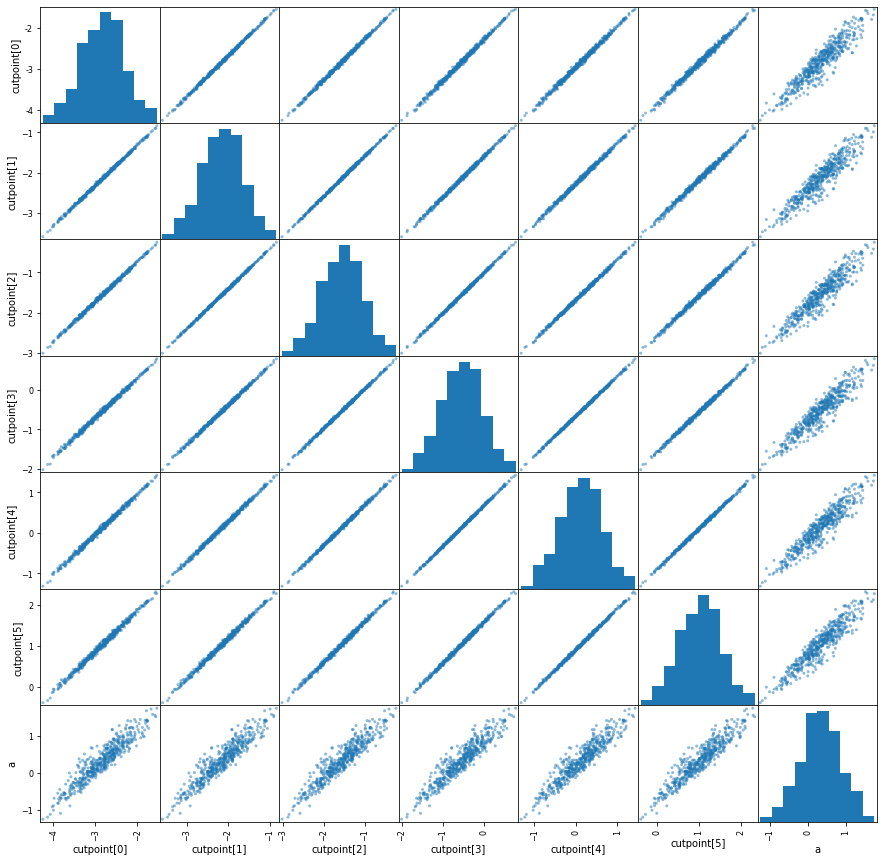

In [559]:
df = pd.DataFrame(
    data=torch.cat([v, samples["a"][:,None]], dim=-1).numpy(),
    columns=[f"cutpoint[{i}]" for i in range(v.shape[-1])] + ["a"]
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pd.plotting.scatter_matrix(df, figsize=(15,15))
plt.show()

In [560]:
def model_m12_7(data, training=False):
    N = data["num_rows"]
    K = data["num_levels"]
    cutpoints = pyro.sample("cutpoints", Normal(-1.5, 1.5).expand([K-1]).to_event(0))
    cutpoints = cutpoints.exp().cumsum(-1).log()
    A, I, C = [data[k] for k in ("action", "intention", "contact")]
    b = {k: pyro.sample("b"+k, Normal(0., 1.)) for k in ("A","C","I","E")}
    d = pyro.sample("delta", Dirichlet(tt(7*[2.])))
    phi = (b["A"]*A + b["C"]*C + b["I"]*I) + b["E"]*(d[None,:]*data["mask"]).sum(dim=1)
    dist = OrderedCategorical(phi, cutpoints)
    if training:
        pyro.sample("R", dist, obs=data["response"])
    else:
        return pyro.sample("R", dist)

In [561]:
m12_7 = train_nuts(model_m12_7, data, 500, 500)

Warmup:   0%|          | 0/1000 [00:00, ?it/s]/home/ecotner/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  
Sample: 100%|██████████| 1000/1000 [05:30,  3.03it/s, step size=1.02e-01, acc. prob=0.930]


OK, that completed MUCH faster than the original run, and I think if you look at the summary/plots below, it is clear that the results are much more significant, and do not suffer from the non-identifiability problem that was troubling us before. The cutpoints are still pretty highly correlated, but not nearly as much as before. If we look at the traceplot/scatterplot, it seems that the education level coefficient $\beta_E$ is also highly correlated with the cutpoints!

In [562]:
m12_7.summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
cutpoints[0]     -3.17      0.20     -3.13     -3.47     -2.90     44.88      1.00
cutpoints[1]     -3.20      0.20     -3.16     -3.47     -2.91     44.24      1.00
cutpoints[2]     -2.73      0.20     -2.68     -3.03     -2.47     44.16      1.00
cutpoints[3]     -1.33      0.20     -1.29     -1.62     -1.07     43.03      1.00
cutpoints[4]     -0.94      0.20     -0.90     -1.21     -0.65     41.30      1.00
cutpoints[5]      0.17      0.20      0.21     -0.12      0.43     42.69      1.00
          bA     -0.71      0.04     -0.71     -0.76     -0.64    364.50      1.00
          bC     -0.96      0.05     -0.96     -1.05     -0.88    292.20      1.00
          bI     -0.72      0.04     -0.72     -0.79     -0.67    368.52      1.01
          bE     -0.42      0.21     -0.37     -0.75     -0.13     45.27      1.00
    delta[0]      0.28      0.16      0.25      0.00      0.52     69.57      1.00
   

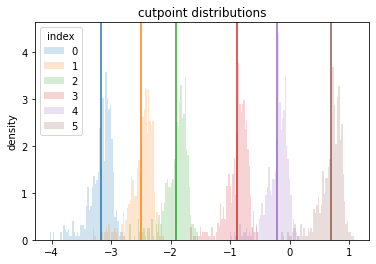

In [563]:
samples = m12_7.get_samples()
v = samples["cutpoints"].exp().cumsum(-1).log()
for i in range(v.shape[-1]):
    plt.hist(v[:,i], bins=50, label=i, alpha=0.2, histtype="stepfilled", density=True)
    plt.axvline(v[:,i].mean(), color=f"C{i}")
plt.legend(title="index")
plt.title("cutpoint distributions")
plt.ylabel("density")
plt.show()

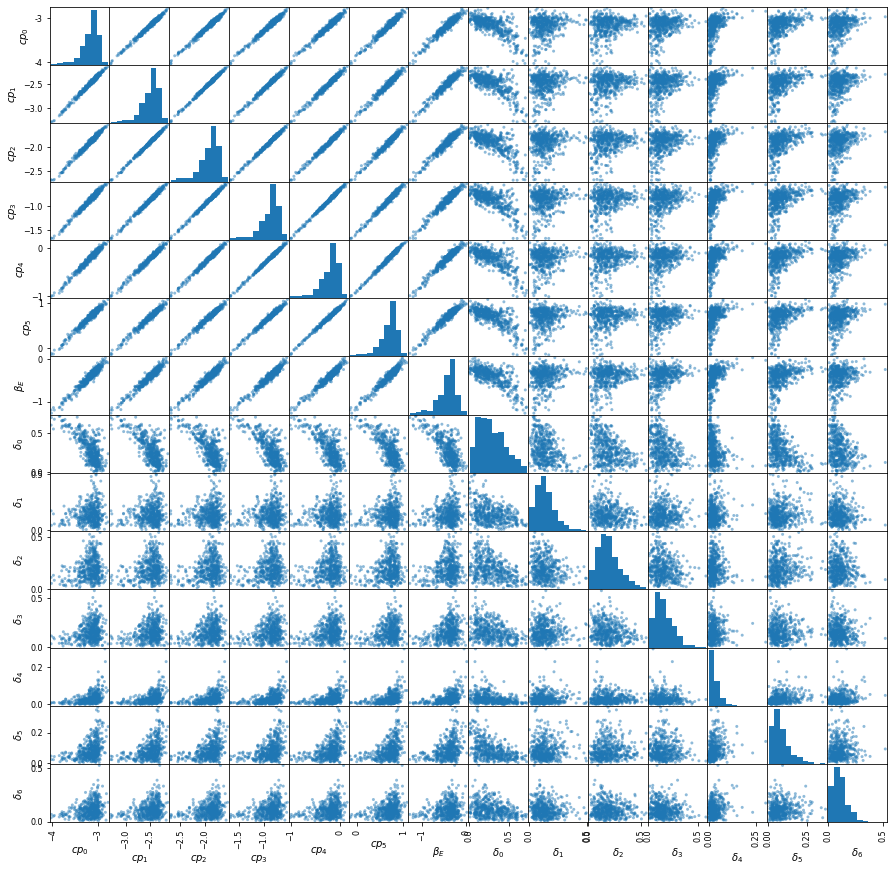

In [572]:
d = samples["delta"]
df = pd.DataFrame(
    data=torch.cat([v, samples["bE"][:,None], d], dim=-1).numpy(),
    columns=[fr"$cp_{i}$" for i in range(v.shape[-1])] + [r"$\beta_E$"] + [fr"$\delta_{i}$" for i in range(d.shape[-1])]
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pd.plotting.scatter_matrix(df, figsize=(15,15))
plt.show()

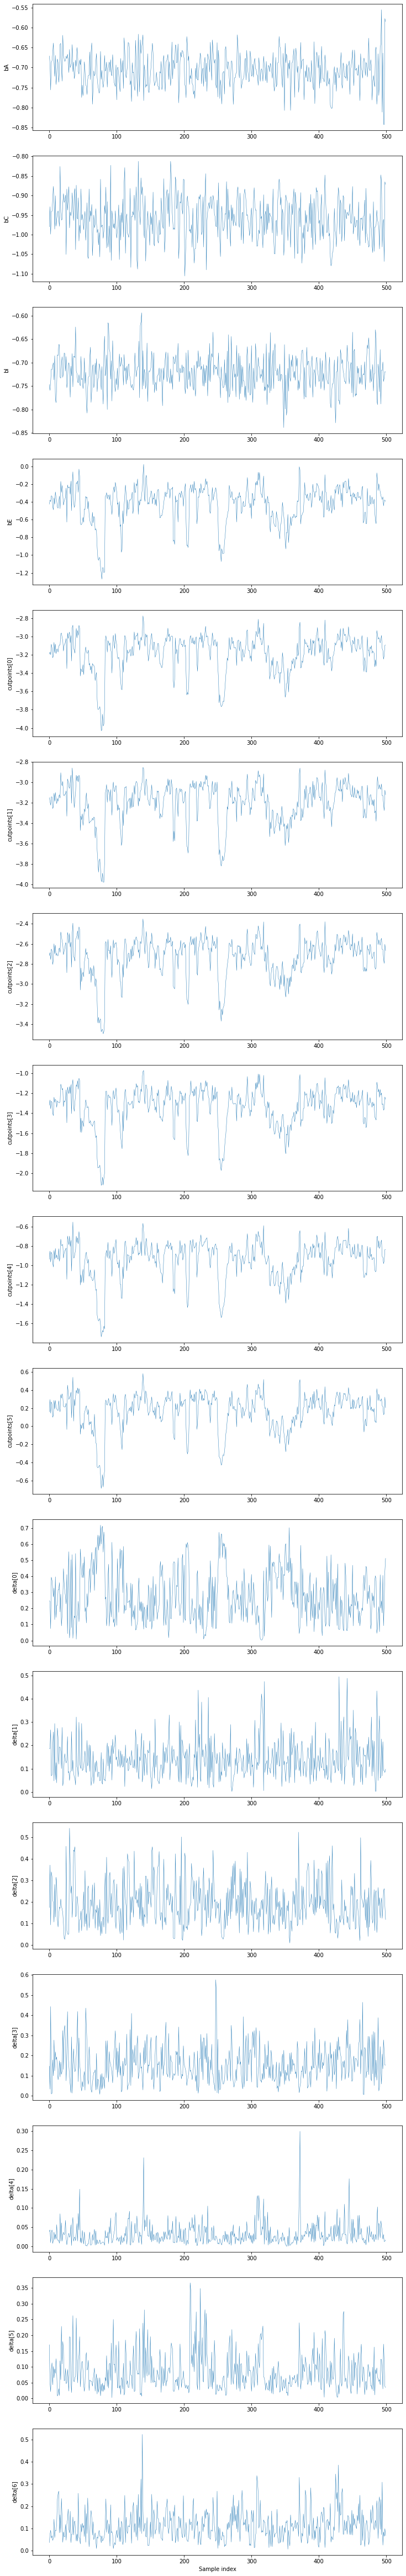

In [566]:
traceplot(unnest_samples(m12_7.get_samples())); plt.show()